# BurnMan - Compute seismic velocities - advanced case

Copyright (C) 2012 - 2015 by the BurnMan team, released under the GNU GPL v2 or later.

This example script is an extension the simple case. It gives suggestions on how to change the geotherm and composition, and how to compare to the seismic model with depth instead of pressures. One can choose to run  the different cells for the various options (press shift+enter on the cell of choice). 


requires:

- geotherms

- seismic models

- compute seismic velocities

- composite mineral helpers

teaches:

- changing composition

- changing geotherm

- changing averaging scheme

- computing self-consistent depth to compare to seismology

### 1. Import modules

Import of relevant modules.

In [1]:
%matplotlib inline
import os, sys, numpy as np, matplotlib.pyplot as plt
sys.path.insert(1,os.path.abspath('..'))
import burnman
from burnman import minerals

### 2. Import seismic model

Here we load the PREM seismic velocity model for comparison.

In [2]:
seismic_model = burnman.seismic.PREM()

We create an array of 20 depths at which we want to evaluate PREM, and then
query the seismic model for the pressure, density, P wave speed, S wave
speed, and bulk sound velocity at those depths

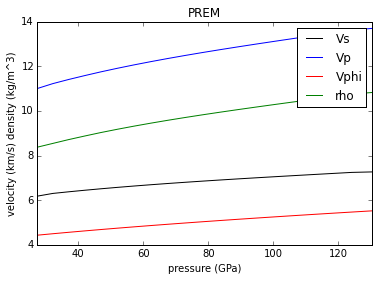

In [3]:
depths = np.linspace(750e3, 2800e3, 20)
pressure, seis_rho, seis_vp, seis_vs, seis_vphi = seismic_model.evaluate(['pressure','density','v_p','v_s','v_phi'], depths)
plt.plot(pressure/1.e9,seis_vs/1.e3,'k',label='Vs')
plt.plot(pressure/1.e9,seis_vp/1.e3,'b',label='Vp')
plt.plot(pressure/1.e9,seis_rho/1.e3,'r',label='Vphi')
plt.plot(pressure/1.e9,seis_vphi/1.e3,'g',label='rho')
plt.xlabel('pressure (GPa)')
plt.ylabel('velocity (km/s) density (kg/m^3)')
plt.xlim(min(pressure)/1.e9,max(pressure)/1.e9)
plt.title('PREM')
plt.legend()
plt.show();

### 3. Input composition

##### Composite I.  Fixed minerals

We define
composite object and name it "rock".  A composite is made by
giving burnman.composite a list of minerals and their molar fractions.
Here "rock" has two constituent minerals: it is 80% Mg perovskite
and 20% periclase.  More than two minerals can simply be added to the composite.

In [4]:
amount_of_perovskite=0.8
rock = burnman.Composite([minerals.SLB_2011.mg_perovskite(), minerals.SLB_2011.periclase()],
  [amount_of_perovskite, 1.0-amount_of_perovskite]  )

##### Composite II. Including iron

In [5]:
amount_perovskite = 0.95
fe_num_perovskite = 0.08
fe_num_periclase  = 0.2
perovskite=minerals.SLB_2011.mg_fe_perovskite()
ferropericlase=minerals.SLB_2011.ferropericlase()
perovskite.set_composition([1.0 - fe_num_perovskite, fe_num_perovskite, 0.0])
ferropericlase.set_composition([1.0 - fe_num_periclase, fe_num_periclase])
rock = burnman.Composite([perovskite, ferropericlase],
  [amount_perovskite, 1.0-amount_perovskite]  )

##### Composite III. Weight percentages

Here is the implementations for weight percentages, where the phase fractions are calculated. The partition coefficient of iron is allowed to vary with depth.

In [6]:
weight_percents = {'Mg':0.38, 'Fe': 0.16, 'Si':0.46, 'Ca':0., 'Al':0.}
Kd_0 = .59 #Fig 5 Nakajima et al 2012

phase_fractions,relative_molar_percent = burnman.\
        					calculate_phase_percents(weight_percents)
iron_content = lambda p,t: burnman.calculate_partition_coefficient\
        					(p,t,relative_molar_percent,Kd_0)

perovskite.set_state(1.e9, 1000.)
def pv_fper_pt_dependent(iron_content):
    pv_fe, fper_fe = iron_content(perovskite.pressure,perovskite.temperature)
    perovskite.set_composition([1.0-pv_fe, pv_fe, 0.0])
    ferropericlase.set_composition([1.0-fper_fe, fper_fe])
    return perovskite, ferropericlase

rock = burnman.Composite([pv_fper_pt_dependent(iron_content)[0], pv_fper_pt_dependent(iron_content)[1]],
   [phase_fractions['pv'], phase_fractions['fp']] )

##### Set method of composite

At this point we want to tell the rock which equation of state to use for
its thermoelastic calculations. Methods available are:

- bm2 -- third order with second order shear modulus (Stixrude & Lithgow-Berteloni 2005)- no temperature effects
- bm3 -- third order method (Stixrude & Lithgow-Berteloni 2005) - no temperature effects
- slb2 -- third order with second order shear modulus (Stixrude & Lithgow-Berteloni 2005)
- slb3 -- third order method (Stixrude & Lithgow-Berteloni 2005)
- mgd2 -- third order with second order shear modulus  (Matas et al. 2007) non-benchmarked
- mgd3 -- third order method (Matas et al. 2007) non-benchmarked

In general, we recommend the 'slb3'
equation of state as the most self-consistent model.  The parameters from
the SLB_2011 mineral library are fit using this model and we suggest not changing this method when using this library. 


In [7]:
rock.set_method('slb3')

### 4. Input temperature

Now we get an array of temperatures at which will be used for computing
the seismic properties of the rock.  Here one can choose between the Brown and Shankland (1981) model or an adiabat.

Geotherm I. Brown & Shankland

In [8]:
temperature = burnman.geotherm.brown_shankland(pressure)
title='Brown&Shankland'

##### Geotherm II. Adiabat

In [9]:
T0=1900 #K anchor temperature
temperature = burnman.geotherm.adiabatic(pressure, T0, rock)
title='adiabat'

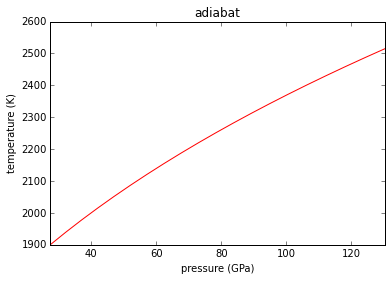

In [10]:
# plot temperature
plt.plot(pressure/1.e9,temperature,'r')
plt.xlim(min(pressure)/1.e9,max(pressure)/1.e9)
plt.title(title)
plt.xlabel('pressure (GPa)')
plt.ylabel('temperature (K)');

### 4. Calculate velocities

    
Here is the step which does the heavy lifting.  burnman.evaluate sets the state of the rock at each of the pressures and temperatures defined,then requests and calculates the requested material properties 
modulus for the rock.  This averaging scheme defaults to Voigt-Reuss-Hill,
but see example_averaging.py for other options.  Finally, it calculates the seismic
wave speeds for the whole rock.  It returns a tuple of density, p-wave velocity
s-wave velocity, bulk sound speed, bulk modulus, and shear modulus.

In [11]:
density, vp, vs, vphi, K, G = rock.evaluate(['density','v_p','v_s','v_phi','K_S','G'], pressure, temperature)

### 5. Plot results

All the work is done except the plotting!  Here we want to plot the seismic wave
speeds and the density against PREM using the matplotlib plotting tools. 
First we plot the results with pressure and then convert to depths to plot with depth.

##### Plots I. As a function of pressure

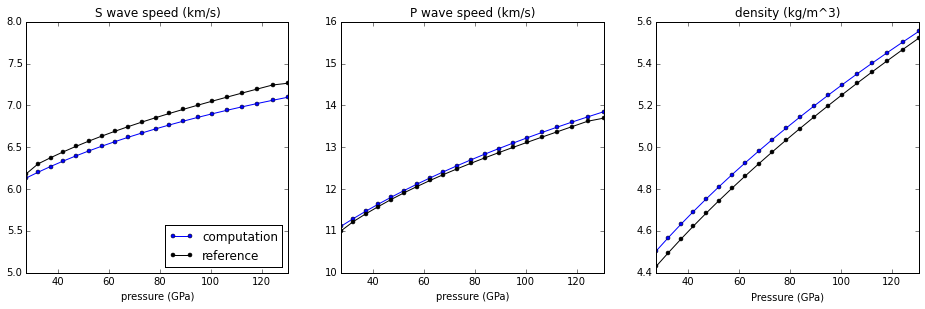

In [12]:
# First, we plot the s-wave speed verses the PREM s-wave speed
plt.figure(figsize=(16,4.5))
plt.subplot(1,3,1)
plt.plot(pressure/1.e9,vs/1.e3,color='b',linestyle='-',marker='o', markerfacecolor='b',markersize=4,label='computation')
plt.plot(pressure/1.e9,seis_vs/1.e3,color='k',linestyle='-',marker='o', markerfacecolor='k',markersize=4,label='reference')
plt.title("S wave speed (km/s)")
plt.xlim(min(pressure)/1.e9,max(pressure)/1.e9)
plt.xlabel('pressure (GPa)')
plt.legend(loc='lower right')
plt.ylim(5,8.0)
  

# Next, we plot the p-wave speed verses the PREM p-wave speed
plt.subplot(1,3,2)
plt.plot(pressure/1.e9,vp/1.e3,color='b',linestyle='-',marker='o',markerfacecolor='b',markersize=4)
plt.plot(pressure/1.e9,seis_vp/1.e3,color='k',linestyle='-',marker='o',markerfacecolor='k',markersize=4)
plt.title("P wave speed (km/s)")
plt.xlabel('pressure (GPa)')
plt.xlim(min(pressure)/1.e9,max(pressure)/1.e9)
plt.ylim(10,16)
    
# Next, we plot the density verses the PREM density
plt.subplot(1,3,3)
plt.plot(pressure/1.e9,density/1.e3,color='b',linestyle='-',marker='o', markerfacecolor='b',markersize=4)
plt.plot(pressure/1.e9,seis_rho/1.e3,color='k',linestyle='-',marker='o', markerfacecolor='k',markersize=4)
plt.xlim(min(pressure)/1.e9,max(pressure)/1.e9)
plt.xlabel("Pressure (GPa)")

plt.title("density (kg/m^3)");